In [20]:
import numpy as np
import pandas as pd
import json

In [21]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [22]:
SYMBOLS = ['COCONUTS','PINA_COLADAS']

# DATA LOADING

In [172]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in SYMBOLS:
        if s in df_grouped.groups:
            markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files, hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        if not sym in hist_trades:
            continue
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [24]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size


def quote_weighted_px_square(quote, levels=5):
    notional, size = 0, 0
    for x in ['bid','ask']:
        notional += np.square(quote[f'{x}_sz'])*quote[x]
        size += np.square(quote[f'{x}_sz'])
   
        for i in range(2, min(quote[f'{x}_levels'], levels)+1):
            notional += quote[f'{x}_{i}']*np.square(quote[f'{x}_sz_{i}'])
            size += np.square(quote[f'{x}_sz_{i}'])
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [76]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 2, 3, 4, 5, 10, 25, 50]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
#     for t in MOVING_WINDOW_TIMES:
#         md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
#         md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
#         md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
#     for t in HIST_PX_TIMES:
#         # Price move since the past
#         md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
#         md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
#         md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
#         md[f'px_move_{t}'].fillna(0, inplace=True)
#         md[f'bid_move_{t}'].fillna(0, inplace=True)
#         md[f'ask_move_{t}'].fillna(0, inplace=True)
        
#         md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
#         # log return
#         md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
#         md[f'log_return_{t}'].fillna(1, inplace=True)
#     md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
#     md['bid_improve'] = md['bid'] > md['bid'].shift(1)
#     md['bid_revert'] = md['bid'] < md['bid'].shift(1)
#     md['ask_improve'] = md['ask'] < md['ask'].shift(1)
#     md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [35]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 'px_move_10': ['mean','std'], 'px_move_50': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)
        
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

## Load

In [77]:
quote_files, trade_files = [], []
data_dir = 'hist_data/island-data-bottle-round-2/'
hist_days = [-1]
quote_files += [f'{data_dir}prices_round_2_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_2_day_{i}_nn.csv' for i in hist_days]

data_dir = 'hist_data/island-data-bottle-round-3/'
hist_days = [0, 1, 2]
quote_files += [f'{data_dir}prices_round_3_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_3_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, [-1,0,1,2])
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [28]:
hist_data_summary(hist_quotes, hist_trades)

COCONUTS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.47,7986.81,-0.02,-0.11,0.86,0.04,154.39,155.38,1.24,1.24,135.51,130.67,131.24,124.54
std,0.61,70.26,2.59,5.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,34249.00,1422.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PINA_COLADAS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.65,14978.42,-0.04,-0.19,0.28,0.03,71.33,71.42,1.35,1.35,64.96,64.45,62.52,62.59
std,0.59,117.09,6.70,15.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,11380.00,1102.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Historical Quote Analysis

COCONUTS
PINA_COLADAS


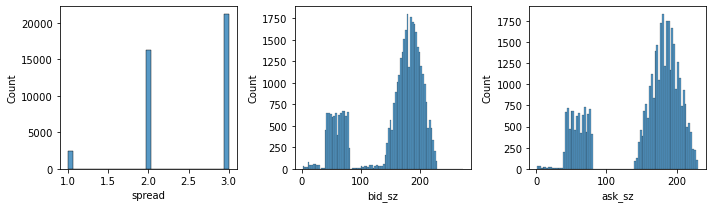

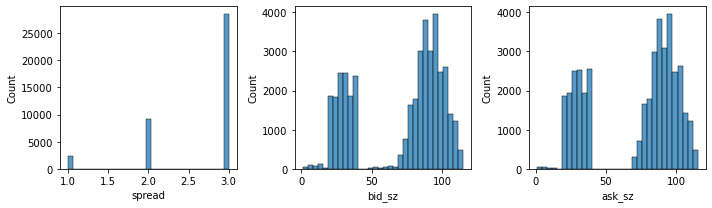

In [29]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

COCONUTS
PINA_COLADAS


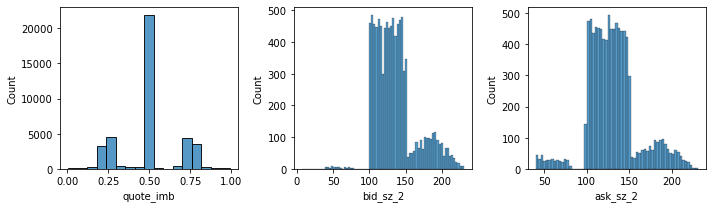

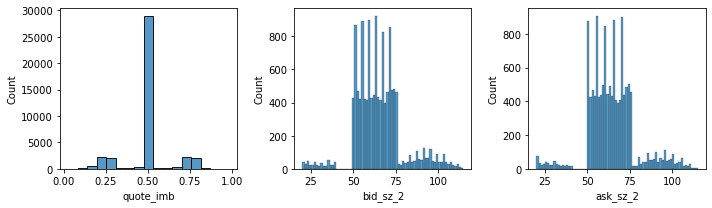

In [30]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['quote_imb','bid_sz_2','ask_sz_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

COCONUTS
PINA_COLADAS


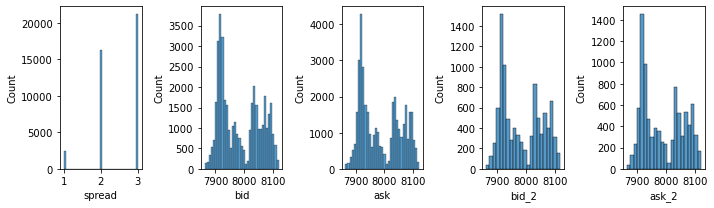

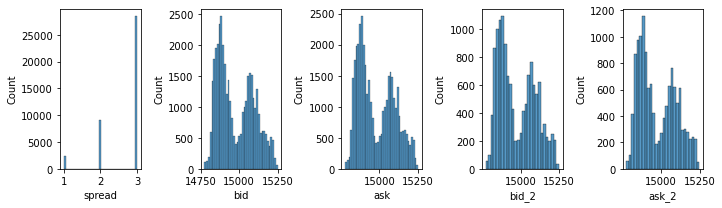

In [31]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

COCONUTS
PINA_COLADAS


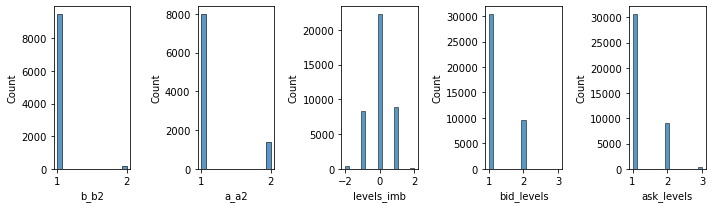

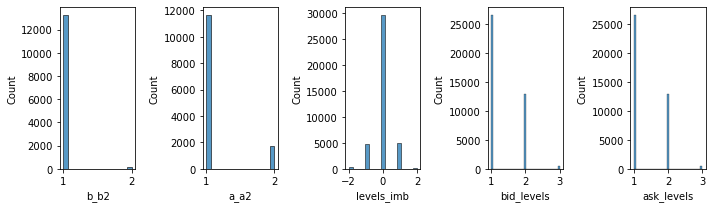

In [32]:
for sym in SYMBOLS:
    quote = hist_quotes[sym].copy()
    quote['b_b2'] = quote['bid'] - quote['bid_2']
    quote['a_a2'] = quote['ask_2'] - quote['ask']
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['b_b2','a_a2','levels_imb', 'bid_levels', 'ask_levels']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

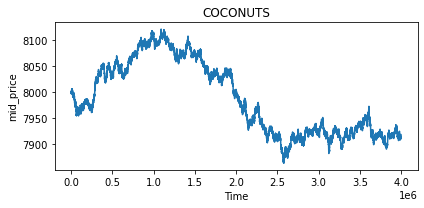

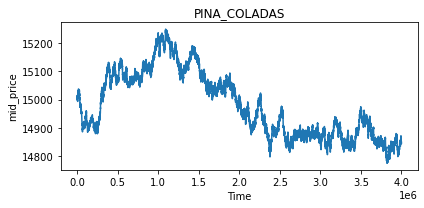

In [36]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

# Historical Trade Analysis

In [37]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades['quantity'].describe().rename(sym))
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
COCONUTS,1422.0,24.085091,20.119571,1.0,8.0,14.0,43.0,79.0
PINA_COLADAS,1102.0,10.326679,9.273540,1.0,3.0,6.0,14.0,40.0


In [38]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades.groupby('timestamp')['quantity'].sum().describe().rename(sym))
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
COCONUTS,1307.0,26.204285,22.499455,5.0,8.0,14.0,46.0,80.0
PINA_COLADAS,1037.0,10.973963,10.215076,2.0,4.0,6.0,14.0,40.0


COCONUTS
PINA_COLADAS


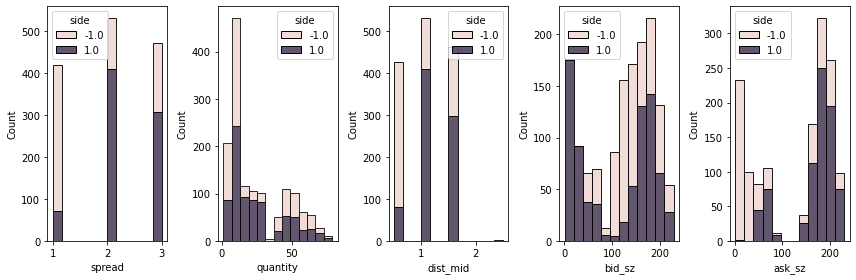

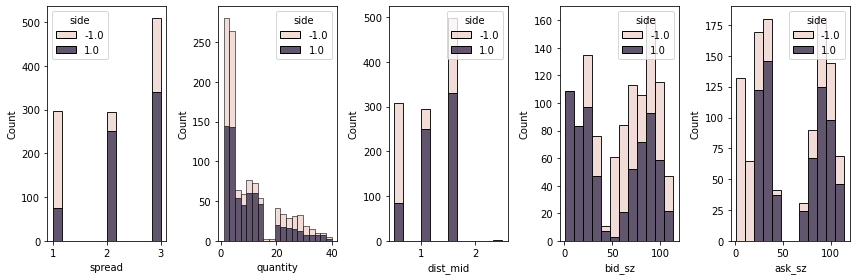

In [39]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['spread'] = trades['ask']-trades['bid']
    trades['dist_mid'] = np.abs(trades['mid_price']-trades['price'])
    
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','quantity', 'dist_mid', 'bid_sz','ask_sz']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

COCONUTS
PINA_COLADAS


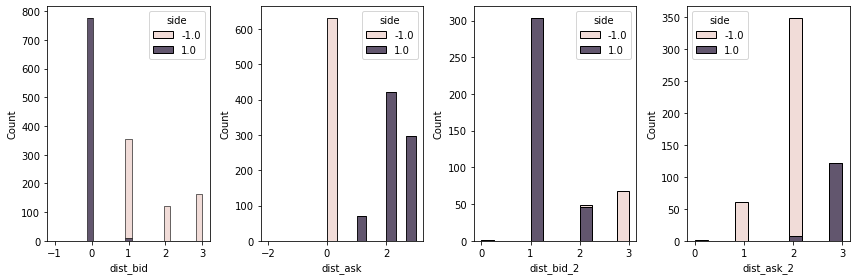

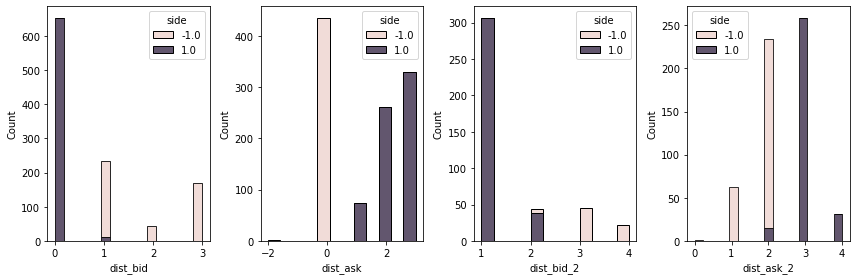

In [40]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['dist_bid'] = trades['price']-trades['bid']
    trades['dist_ask'] = trades['ask']-trades['price']
    
    trades['dist_bid_2'] = trades['price']-trades['bid_2']
    trades['dist_ask_2'] = trades['ask_2']-trades['price']
    
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(12,4))
    for i, col in enumerate(['dist_bid','dist_ask','dist_bid_2','dist_ask_2']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

# Pairs Analysis

In [78]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

quote1 = hist_quotes[sym1].drop(columns='day').copy()
quote2 = hist_quotes[sym2].drop(columns='day').copy()

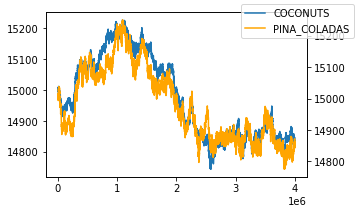

In [71]:
col = 'fair_price'
quote1['fair_price'] = quote1['mid_price']*15/8
quote2['fair_price'] = quote2['mid_price']

f, ax = plt.subplots(figsize=(5,3))
ax.plot('timestamp',col, data=quote1, label=sym1)
ax2 = ax.twinx()
ax2.plot('timestamp',col, data=quote2, label=sym2, color='orange')
f.legend()
plt.tight_layout()

count    40000.000000
mean         0.093416
std          1.005868
min         -2.548583
25%         -0.568824
50%          0.063743
75%          0.684006
max          3.538484
Name: signal, dtype: float64


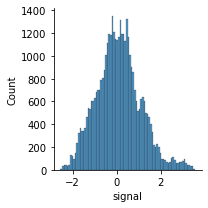

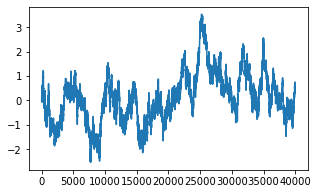

In [379]:
px_ratio = 100*(quote2['mid_price']/quote1['mid_price']-15/8)*2.25
# px_ratio = 100*(quote2['mid_price']/(quote1['mid_price']+7000)-1)
# px_ratio = (quote2['mid_price']-15000)-2*(quote1['mid_price']-8000)
# px_ratio /= 30

signal = px_ratio.rename('signal')
print(signal.describe())
sns.displot(signal,height=3)

f, ax = plt.subplots(figsize=(5,3))
ax.plot(signal)

In [90]:
columns = ['timestamp', 'mid_price', 'bid', 'bid_sz','ask', 'ask_sz','fair_v1', 'bid_2', 'bid_sz_2','ask_2', 'ask_sz_2']

pair_data = quote1[columns].merge(quote2[columns], on=['timestamp'], suffixes=('_'+sym1,'_'+sym2))
pair_data['signal'] = 100*(pair_data['mid_price_PINA_COLADAS']/pair_data['mid_price_COCONUTS']-15/8)

In [ ]:
def backtest_pairs(pair_data):
    for 
    

In [96]:
trades = []
positions = []
last_position = [0,0]

for time, state in pair_data.iterrows():
    if signal > 0.3:
        if positions[0]

SyntaxError: invalid syntax (Temp/ipykernel_1732/26558135.py, line 7)

# Backtest Analysis

In [329]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})$")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")

    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    observations = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": 0, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            extract_observations(observations, state)
            
    positions = pd.DataFrame(positions)
    observations = pd.DataFrame(observations)
    
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths, observations

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_observations(observations, state):
    obs = state['observations']
    for p in obs:
        observations.append({"timestamp": state['timestamp'], "symbol": p, "observation": obs[p]})
        
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return


def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']
    
def fix_fill_volume(x):
    fill_qty = np.clip(x['fill_qty']-x['quantity'].cumsum()-x['quantity'].iat[0], 0, None)
    return fill_qty

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)

    gcols = ['symbol','timestamp','price','side']
    fill_data = fills.groupby(gcols)[['quantity']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    fill_data['i'] = 0
    orders['i'] = orders.groupby(gcols).cumcount()
    orders = orders.merge(fill_data, how='left', on=gcols+['i']).drop('i',axis=1)
    orders['fill_qty'].fillna(0, inplace=True)    
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby('symbol')[col].transform(pd.Series.cumsum)
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths, observations = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    dfs['observations'] = observations
    
    if by_symbol:
        for table in dfs:
            if not dfs[table].empty:
                dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [175]:
def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

## Load

COCONUTS: PnL=-76.0 | Trades=6.0 | MarketVol=1682 | Volume Filled=84.0 | POV=0.048 | Shares/Step=0.084 | PnL/Share=-0.9048
PINA_COLADAS: PnL=-109.5 | Trades=5.0 | MarketVol=637 | Volume Filled=31.0 | POV=0.046 | Shares/Step=0.031 | PnL/Share=-3.532
Total PnL=-185.5


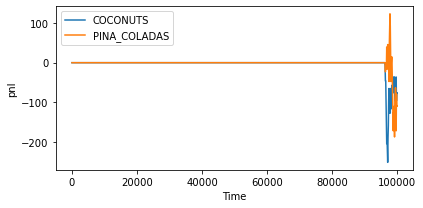

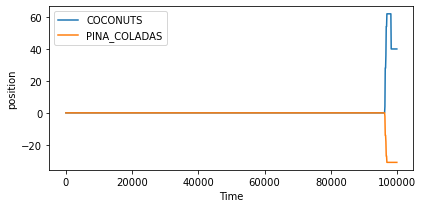

In [412]:
log_file = "backtest_logs/backtest.log"
# log_file = "round3_logs/6bb4c7ed-464c-4d08-941c-5e9a07587e0e.log"
log_file = "round3_logs/" + "086a8d22-ca6f-4fac-bb71-5c53245c09f1.log"

SYMBOLS = ['COCONUTS','PINA_COLADAS']

dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

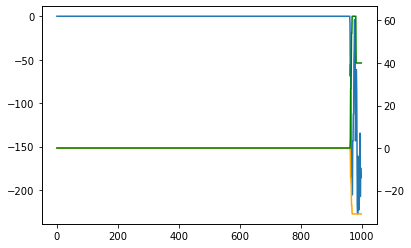

In [413]:
pair_pnl = dfs['positions']['COCONUTS']['pnl'] + dfs['positions']['PINA_COLADAS']['pnl']

ax = pair_pnl.plot()
ax2 = ax.twinx()
ax2.plot(dfs['positions']['PINA_COLADAS']['position'], color='orange')
ax2.plot(dfs['positions']['COCONUTS']['position'], color='green')

In [414]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

backtest_quote1 = dfs['quote'][sym1]
backtest_quote2 = dfs['quote'][sym2]

count    999.000000
mean       0.006240
std        0.379251
min       -1.250000
25%       -0.150000
50%        0.016667
75%        0.233333
max        0.783333
Name: signal, dtype: float64


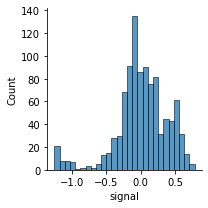

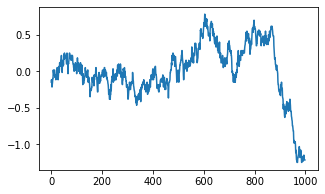

In [419]:
# px_ratio = 100*(backtest_quote2['mid_price']/backtest_quote1['mid_price']-15/8)*2.25
# px_ratio = 100*(quote2['mid_price']/(quote1['mid_price']+7000)-1)
px_ratio = ((backtest_quote2['mid_price']-15000)-2*(backtest_quote1['mid_price']-8000))/(-30)

signal = px_ratio.rename('signal')
print(signal.describe())
sns.displot(signal,height=3)

f, ax = plt.subplots(figsize=(5,3))
ax.plot(signal)

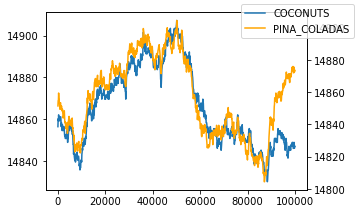

In [422]:
col = 'fair_price'
backtest_quote1['fair_price'] = backtest_quote1['mid_price']*15/8
backtest_quote2['fair_price'] = backtest_quote2['mid_price']

f, ax = plt.subplots(figsize=(5,3))
ax.plot('timestamp',col, data=backtest_quote1, label=sym1)
ax2 = ax.twinx()
ax2.plot('timestamp',col, data=backtest_quote2, label=sym2, color='orange')
f.legend()
plt.tight_layout()